In [114]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
import sys
sys.path.append("../../Code")
import vader
import settings as s
import utils 
import seaborn as sns 
import afinns as af
import s140
import opinion_lexicon as op
import so_cal as sc
import sentiment as sent
import analysis
import languages as lang

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [193]:
reviews = pd.read_csv('reviews_with_sent.csv', index_col=0)

In [194]:
reviews = reviews[~reviews['so_cal'].isnull()]

In [195]:
reviews.head(3)

,idReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,other_langs,translated,afinn,vader,s140,opinion_bow,opinion_freq,Affin-sentence,Vader-sentence,opinion_bow-sentence,opinion_freq-sentence,so_cal,s140-sentence,so_cal-sentence
201,439,247449510,2018-03-28,2635362,4484,5688,"Great value, easy to get to",N,6,1,en,1.0,en,0.857139,0,None,4.0,0.8555,2,0.500000,0.333333,[4.0],[0.8555],[0.5],[0.3333333333333333],2.750000,[2],[2.75]
202,440,248421191,2018-03-31,179985958,4484,5688,Robin’s place was great. Very spacious and we ...,N,55,5,en,1.0,en,0.999995,0,NaN,5.0,0.8313,2,0.136364,0.072727,"[3.0, 1.0, -1.0, -1.0, 3.0]","[0.6249, 0.0, -0.0516, -0.1531, 0.6588]","[0.3333333333333333, 0.3333333333333333, 0.111...","[0.2, 0.1111111111111111, 0.04, 0.0, 0.1666666...",2.740000,"[2, 2, 2, 2, 2]","[4.0, 4.8, 2.4, -1.5, 8.0]"
203,441,22938,2010-01-03,61471,4989,7118,Good location - easy access to Times Square an...,N,40,5,en,1.0,en,0.999997,0,NaN,14.0,0.9758,4,0.230769,0.150000,"[4.0, 3.0, 2.0, 3.0, 2.0]","[0.7003, 0.7678, 0.4754, 0.6588, 0.3612]","[0.2857142857142857, 0.1, 0.5, 0.5, 0.2]","[0.2, 0.058823529411764705, 0.25, 0.5, 0.14285...",3.628571,"[2, 2, 2, 2, 2]","[2.0, 4.5, 2.4, 8.0, 0.0]"


# Whole reviews

## Afinn

In [196]:
reviews['afinn'].describe()

count    225448.000000
mean         11.917010
std           7.803138
min         -35.000000
25%           7.000000
50%          11.000000
75%          16.000000
max         116.000000
Name: afinn, dtype: float64

In [197]:
afinn_table = utils.create_normalised_table(reviews, 'afinn', 'log')

In [198]:
afinn_table[afinn_table['trans_afinn-adj-2-norm']<= 0.3].head()

,id,comments,afinn,afinn-norm,trans_afinn,trans_afinn_norm,trans_afinn-adj-1,trans_afinn-adj-1-norm,trans_afinn-adj-2,trans_afinn-adj-2-norm
232,6236,Dead cockroaches. Cat hair everywhere. Not ver...,-1.0,0.225166,0.203076,0.292977,0.203076,0.142789,0.203076,0.295880
301,24023,Although i was unable to make the stay due to ...,-2.0,0.218543,0.197656,0.285157,0.197656,0.113059,0.197656,0.278891
481,2295972,We've already stayed five times with airbnb an...,-9.0,0.172185,0.158870,0.229201,0.177044,0.000000,0.158870,0.157321
522,8945867,A very well-situated apartment several blocks ...,-1.0,0.225166,0.203076,0.292977,0.203076,0.142789,0.203076,0.295880
538,12649702,My first experience with Airbnb in this apartm...,-12.0,0.152318,0.141775,0.204539,0.177044,0.000000,0.141775,0.103741


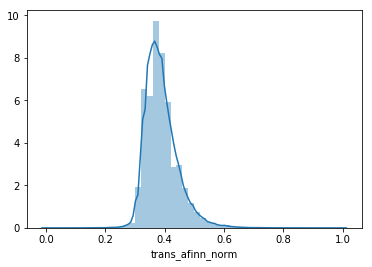

In [199]:
sns.distplot(afinn_table['trans_afinn_norm'])
plt.show()

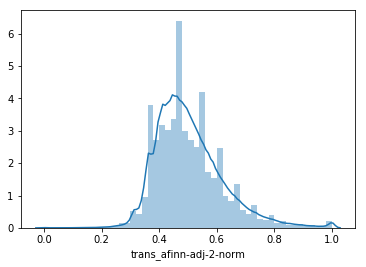

In [200]:
sns.distplot(afinn_table['trans_afinn-adj-2-norm'])
plt.show()

In [201]:
afinn_chosen_o = ["trans_afinn_norm", 'trans_afinn-adj-2-norm']

## Vader

In [202]:
reviews['vader'].describe()

count    225448.000000
mean          0.867421
std           0.226846
min          -0.996400
25%           0.864100
50%           0.940100
75%           0.971900
max           0.999600
Name: vader, dtype: float64

In [203]:
vader_table = utils.create_normalised_table(reviews, 'vader', 'pwr')

In [204]:
vader_table[vader_table['trans_vader_norm']<0.2].head()

,id,comments,vader,vader-norm,trans_vader,trans_vader_norm,trans_vader-adj-1,trans_vader-adj-1-norm,trans_vader-adj-2,trans_vader-adj-2-norm
232,6236,Dead cockroaches. Cat hair everywhere. Not ver...,-0.7766,0.110120,0.012126,0.012126,0.713437,0.0,0.558036,0.0
241,21244,You must be in shape to visit Tina apartmant. ...,-0.4402,0.278657,0.077650,0.077650,0.713437,0.0,0.558036,0.0
244,106703,Is glad to stay in Tina's Apt. the apt is just...,-0.2023,0.397846,0.158281,0.158281,0.713437,0.0,0.558036,0.0
324,1076344,if you want someone bothering you about using ...,-0.3182,0.339780,0.115450,0.115450,0.713437,0.0,0.558036,0.0
375,29344,The apartment is not the place shown in the pi...,-0.7701,0.113377,0.012854,0.012854,0.713437,0.0,0.558036,0.0


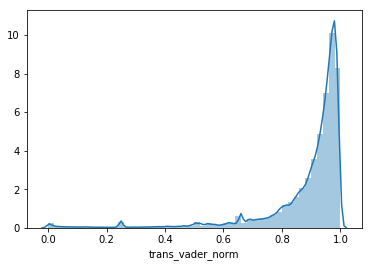

In [205]:
sns.distplot(vader_table['trans_vader_norm'])
plt.show()

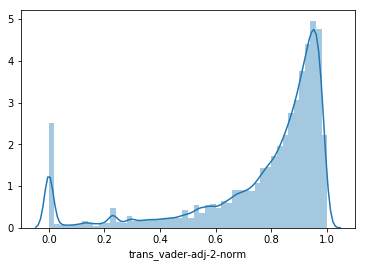

In [206]:
sns.distplot(vader_table['trans_vader-adj-2-norm'])
plt.show()

In [207]:
vader_chosen_o = ["trans_vader_norm", 'trans_vader-adj-2-norm']

# S-140

In [18]:
reviews['s140'].describe()

count    225448.000000
mean          3.272489
std           1.164753
min           0.000000
25%           2.000000
50%           4.000000
75%           4.000000
max           4.000000
Name: s140, dtype: float64

In [19]:
s140_table = utils.create_normalised_table(reviews, 's140')

In [20]:
s140_table.head()

,id,comments,s140,s140-norm,s140-adj-1,s140-adj-1-norm,s140-adj-2,s140-adj-2-norm
201,247449510,"Great value, easy to get to",2,0.5,2,0.5,2,0.5
202,248421191,Robin’s place was great. Very spacious and we ...,2,0.5,2,0.5,2,0.5
203,22938,Good location - easy access to Times Square an...,4,1.0,4,1.0,4,1.0
204,234213,We had the best possible time in NYC and Russe...,4,1.0,4,1.0,4,1.0
205,264416,Three of us stayed at this place for a week- i...,4,1.0,4,1.0,4,1.0


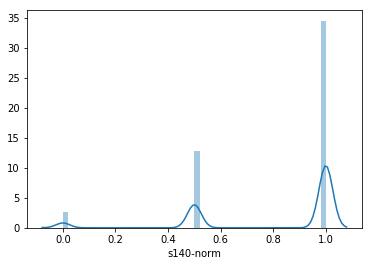

In [21]:
sns.distplot(s140_table['s140-norm'])
plt.show()

In [22]:
s140_chosen_o = ["s140-norm"]

# So Cal

In [23]:
reviews['so_cal'].describe()

count    225448.000000
mean          2.609321
std           1.542166
min         -15.000000
25%           1.803030
50%           2.500000
75%           3.283333
max          20.000000
Name: so_cal, dtype: float64

In [24]:
so_cal_table = utils.create_normalised_table(reviews, 'so_cal', "log")

In [25]:
so_cal_table.head()

,id,comments,so_cal,so_cal-norm,trans_so_cal,trans_so_cal_norm,trans_so_cal-adj-1,trans_so_cal-adj-1-norm,trans_so_cal-adj-2,trans_so_cal-adj-2-norm
201,247449510,"Great value, easy to get to",2.750000,0.507143,0.410216,0.591816,0.410216,0.535738,0.410216,0.520422
202,248421191,Robin’s place was great. Very spacious and we ...,2.740000,0.506857,0.410026,0.591543,0.410026,0.534056,0.410026,0.519460
203,22938,Good location - easy access to Times Square an...,3.628571,0.532245,0.426734,0.615647,0.426734,0.682306,0.426734,0.604175
204,234213,We had the best possible time in NYC and Russe...,3.307143,0.523061,0.420722,0.606974,0.420722,0.628964,0.420722,0.573694
205,264416,Three of us stayed at this place for a week- i...,2.785714,0.508163,0.410893,0.592793,0.410893,0.541743,0.410893,0.523853


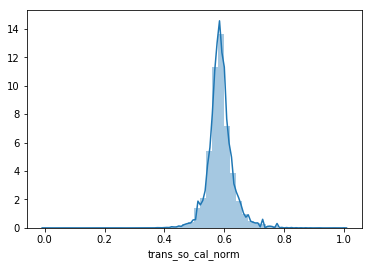

In [26]:
sns.distplot(so_cal_table['trans_so_cal_norm'])
plt.show()

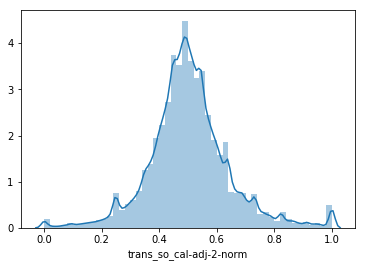

In [27]:
sns.distplot(so_cal_table['trans_so_cal-adj-2-norm'])
plt.show()

In [28]:
so_cal_chosen_o = ["trans_so_cal_norm", 'trans_so_cal-adj-2-norm']

# Opinion_BOW

In [29]:
reviews['opinion_bow'].describe()

count    225448.000000
mean          0.217291
std           0.123224
min          -1.000000
25%           0.136364
50%           0.200000
75%           0.285714
max           1.000000
Name: opinion_bow, dtype: float64

In [30]:
op_bow_table = utils.create_normalised_table(reviews, 'opinion_bow', "log")

In [31]:
op_bow_table.head()

,id,comments,opinion_bow,opinion_bow-norm,trans_opinion_bow,trans_opinion_bow_norm,trans_opinion_bow-adj-1,trans_opinion_bow-adj-1-norm,trans_opinion_bow-adj-2,trans_opinion_bow-adj-2-norm
201,247449510,"Great value, easy to get to",0.500000,0.750000,0.559616,0.807355,0.559616,0.964525,0.559616,0.765443
202,248421191,Robin’s place was great. Very spacious and we ...,0.136364,0.568182,0.449917,0.649093,0.449917,0.375000,0.449917,0.428571
203,22938,Good location - easy access to Times Square an...,0.230769,0.615385,0.479573,0.691878,0.479573,0.534373,0.479573,0.519642
204,234213,We had the best possible time in NYC and Russe...,0.294118,0.647059,0.498991,0.719892,0.498991,0.638727,0.498991,0.579272
205,264416,Three of us stayed at this place for a week- i...,0.230769,0.615385,0.479573,0.691878,0.479573,0.534373,0.479573,0.519642


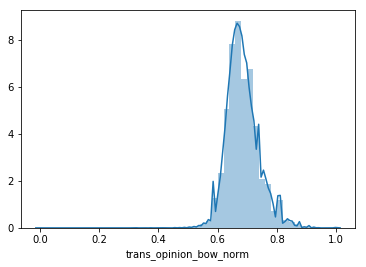

In [32]:
sns.distplot(op_bow_table['trans_opinion_bow_norm'])
plt.show()

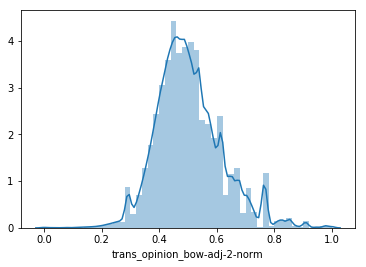

In [33]:
sns.distplot(op_bow_table['trans_opinion_bow-adj-2-norm'])
plt.show()

In [34]:
op_bow_table[op_bow_table['trans_opinion_bow-adj-2-norm'] <0.2].head(3)

,id,comments,opinion_bow,opinion_bow-norm,trans_opinion_bow,trans_opinion_bow_norm,trans_opinion_bow-adj-1,trans_opinion_bow-adj-1-norm,trans_opinion_bow-adj-2,trans_opinion_bow-adj-2-norm
324,1076344,if you want someone bothering you about using ...,-0.142857,0.428571,0.356675,0.514573,0.380137,0.0,0.356675,0.142237
467,1254529,"The location is great, Shun was nice and accom...",-0.125000,0.437500,0.362905,0.523562,0.380137,0.0,0.362905,0.161370
481,2295972,We've already stayed five times with airbnb an...,-0.142857,0.428571,0.356675,0.514573,0.380137,0.0,0.356675,0.142237


In [35]:
op_bow_chosen_o = ["trans_opinion_bow_norm", 'trans_opinion_bow-adj-2-norm']

# OP Frequency

In [36]:
reviews['opinion_freq'].describe()

count    225448.000000
mean          0.125937
std           0.083823
min          -0.500000
25%           0.073171
50%           0.109589
75%           0.159091
max           0.857143
Name: opinion_freq, dtype: float64

In [37]:
op_freq_table = utils.create_normalised_table(reviews, 'opinion_freq', "log")

In [38]:
op_freq_table[op_freq_table['trans_opinion_freq-adj-2-norm'] < 0.3].head(3)

,id,comments,opinion_freq,opinion_freq-norm,trans_opinion_freq,trans_opinion_freq_norm,trans_opinion_freq-adj-1,trans_opinion_freq-adj-1-norm,trans_opinion_freq-adj-2,trans_opinion_freq-adj-2-norm
300,21854,Adrienne was very helpful and informative for ...,-0.027027,0.348506,0.298998,0.431362,0.298998,0.069003,0.298998,0.253716
301,24023,Although i was unable to make the stay due to ...,-0.034483,0.343013,0.294915,0.425473,0.294915,0.045568,0.294915,0.240325
324,1076344,if you want someone bothering you about using ...,-0.071429,0.315789,0.274437,0.395929,0.286978,0.000000,0.274437,0.173147


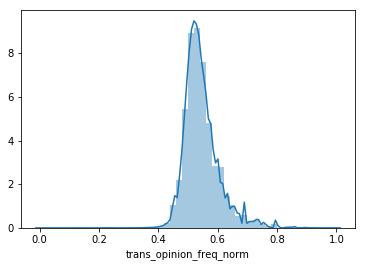

In [39]:
sns.distplot(op_freq_table['trans_opinion_freq_norm'])
plt.show()

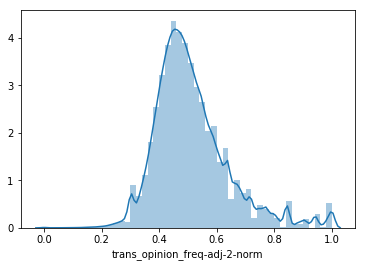

In [40]:
sns.distplot(op_freq_table['trans_opinion_freq-adj-2-norm'])
plt.show()

In [41]:
op_freq_chosen_o =  ['trans_opinion_freq_norm', 'trans_opinion_freq-adj-2-norm']

# Sentiment by Sentence

## Afinn

In [42]:
afinn_sent_table = utils.create_normalised_sent_table(reviews, 'Affin-sentence')

In [43]:
afinn_sent_table.head()

,id,comments,Affin-sentence,Affin-sentence-norm,Affin-sentence-adj-1,Affin-sentence-adj-1-norm,Affin-sentence-adj-2,Affin-sentence-adj-2-norm
201,247449510,"Great value, easy to get to",[4.0],[0.403],[4.0],[0.625],[4.0],[0.571]
202,248421191,Robin’s place was great. Very spacious and we ...,"[3.0, 1.0, -1.0, -1.0, 3.0]","[0.387, 0.355, 0.323, 0.323, 0.387]","[3.0, 1.0, -1.0, -1.0, 3.0]","[0.562, 0.438, 0.312, 0.312, 0.562]","[3.0, 1.0, -1.0, -1.0, 3.0]","[0.536, 0.464, 0.393, 0.393, 0.536]"
203,22938,Good location - easy access to Times Square an...,"[4.0, 3.0, 2.0, 3.0, 2.0]","[0.403, 0.387, 0.371, 0.387, 0.371]","[4.0, 3.0, 2.0, 3.0, 2.0]","[0.625, 0.562, 0.500, 0.562, 0.500]","[4.0, 3.0, 2.0, 3.0, 2.0]","[0.571, 0.536, 0.500, 0.536, 0.500]"
204,234213,We had the best possible time in NYC and Russe...,"[4.0, 7.0, 2.0, 6.0, 3.0, 4.0, 3.0, 7.0]","[0.403, 0.452, 0.371, 0.435, 0.387, 0.403, 0.3...","[4.0, 7.0, 2.0, 6.0, 3.0, 4.0, 3.0, 7.0]","[0.625, 0.812, 0.500, 0.750, 0.562, 0.625, 0.5...","[4.0, 7.0, 2.0, 6.0, 3.0, 4.0, 3.0, 7.0]","[0.571, 0.679, 0.500, 0.643, 0.536, 0.571, 0.5..."
205,264416,Three of us stayed at this place for a week- i...,"[9.0, 3.0, -1.0, 2.0]","[0.484, 0.387, 0.323, 0.371]","[9.0, 3.0, -1.0, 2.0]","[0.938, 0.562, 0.312, 0.500]","[9.0, 3.0, -1.0, 2.0]","[0.750, 0.536, 0.393, 0.500]"


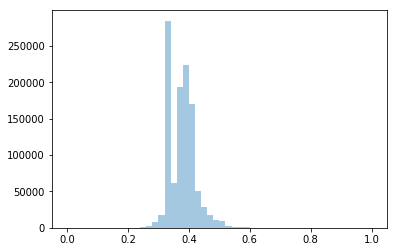

In [44]:
sns.distplot(utils.flatten(afinn_sent_table['Affin-sentence-norm']), kde=False)
plt.show()

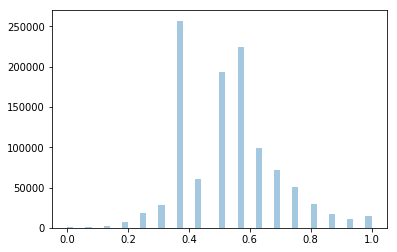

In [45]:
sns.distplot(utils.flatten(afinn_sent_table['Affin-sentence-adj-1-norm']), kde=False)
plt.show()

In [46]:
afinn_chosen_s = ['Affin-sentence-norm', 'Affin-sentence-adj-1-norm']

# Vader Sentence

In [48]:
vader_sent_table = utils.create_normalised_sent_table(reviews, 'Vader-sentence')

In [49]:
vader_sent_table.head(3)

,id,comments,Vader-sentence,Vader-sentence-norm,Vader-sentence-adj-1,Vader-sentence-adj-1-norm,Vader-sentence-adj-2,Vader-sentence-adj-2-norm
201,247449510,"Great value, easy to get to",[0.8555],[0.929],[0.8555],[0.923],[0.8555],[0.929]
202,248421191,Robin’s place was great. Very spacious and we ...,"[0.6249, 0.0, -0.0516, -0.1531, 0.6588]","[0.813, 0.498, 0.472, 0.421, 0.830]","[0.6249, 0.0, -0.0516, -0.1531, 0.6588]","[0.798, 0.458, 0.430, 0.375, 0.817]","[0.6249, 0.0, -0.0516, -0.1531, 0.6588]","[0.813, 0.498, 0.472, 0.421, 0.830]"
203,22938,Good location - easy access to Times Square an...,"[0.7003, 0.7678, 0.4754, 0.6588, 0.3612]","[0.851, 0.885, 0.738, 0.830, 0.680]","[0.7003, 0.7678, 0.4754, 0.6588, 0.3612]","[0.839, 0.876, 0.717, 0.817, 0.655]","[0.7003, 0.7678, 0.4754, 0.6588, 0.3612]","[0.851, 0.885, 0.738, 0.830, 0.680]"


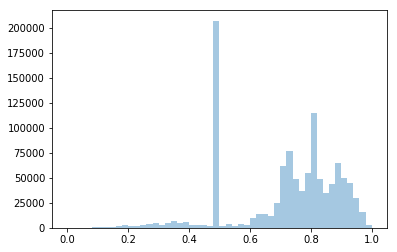

In [50]:
sns.distplot(utils.flatten(vader_sent_table['Vader-sentence-norm']), kde=False)
plt.show()

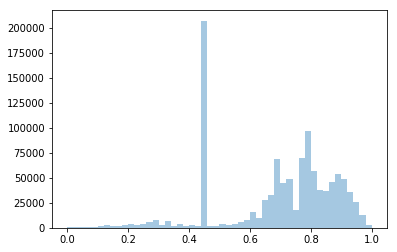

In [51]:
sns.distplot(utils.flatten(vader_sent_table['Vader-sentence-adj-1-norm']), kde=False)
plt.show()

In [52]:
vader_chosen_s = ['Vader-sentence-norm', 'Vader-sentence-adj-1-norm']

# S140 Sentence

In [53]:
s140_sent_table = utils.create_normalised_sent_table(reviews, 's140-sentence')

../../Code/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  row_vals.append(format((v-min)/(max - min), ".3f"))


In [54]:
s140_sent_table.head()

,id,comments,s140-sentence,s140-sentence-norm,s140-sentence-adj-1,s140-sentence-adj-1-norm,s140-sentence-adj-2,s140-sentence-adj-2-norm
201,247449510,"Great value, easy to get to",[2.0],[0.500],[2.0],[nan],[2.0],[nan]
202,248421191,Robin’s place was great. Very spacious and we ...,"[2.0, 2.0, 2.0, 2.0, 2.0]","[0.500, 0.500, 0.500, 0.500, 0.500]","[2.0, 2.0, 2.0, 2.0, 2.0]","[nan, nan, nan, nan, nan]","[2.0, 2.0, 2.0, 2.0, 2.0]","[nan, nan, nan, nan, nan]"
203,22938,Good location - easy access to Times Square an...,"[2.0, 2.0, 2.0, 2.0, 2.0]","[0.500, 0.500, 0.500, 0.500, 0.500]","[2.0, 2.0, 2.0, 2.0, 2.0]","[nan, nan, nan, nan, nan]","[2.0, 2.0, 2.0, 2.0, 2.0]","[nan, nan, nan, nan, nan]"
204,234213,We had the best possible time in NYC and Russe...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.5...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[nan, nan, nan, nan, nan, nan, nan, nan]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[nan, nan, nan, nan, nan, nan, nan, nan]"
205,264416,Three of us stayed at this place for a week- i...,"[4.0, 2.0, 2.0, 2.0]","[1.000, 0.500, 0.500, 0.500]","[2.0, 2.0, 2.0, 2.0]","[nan, nan, nan, nan]","[2.0, 2.0, 2.0, 2.0]","[nan, nan, nan, nan]"


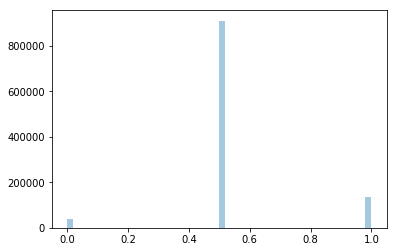

In [55]:
sns.distplot(utils.flatten(s140_sent_table['s140-sentence-norm']), kde=False)
plt.show()

In [56]:
s140_chosen_s = ['s140-sentence-norm']

# SO_CAL Sentence

In [57]:
so_cal_sent_table = utils.create_normalised_sent_table(reviews, 'so_cal-sentence')

In [58]:
so_cal_sent_table.head(3)

,id,comments,so_cal-sentence,so_cal-sentence-norm,so_cal-sentence-adj-1,so_cal-sentence-adj-1-norm,so_cal-sentence-adj-2,so_cal-sentence-adj-2-norm
201,247449510,"Great value, easy to get to",[2.75],[0.374],[2.75],[0.571],[2.75],[0.541]
202,248421191,Robin’s place was great. Very spacious and we ...,"[4.0, 4.8, 2.4, -1.5, 8.0]","[0.388, 0.397, 0.370, 0.325, 0.434]","[4.0, 4.8, 2.4, -1.5, 8.0]","[0.661, 0.718, 0.546, 0.268, 0.946]","[4.0, 4.8, 2.4, -1.5, 8.0]","[0.592, 0.624, 0.527, 0.367, 0.755]"
203,22938,Good location - easy access to Times Square an...,"[2.0, 4.5, 2.4, 8.0, 0.0]","[0.365, 0.394, 0.370, 0.434, 0.342]","[2.0, 4.5, 2.4, 8.0, 0.0]","[0.518, 0.696, 0.546, 0.946, 0.375]","[2.0, 4.5, 2.4, 8.0, 0.0]","[0.510, 0.612, 0.527, 0.755, 0.429]"


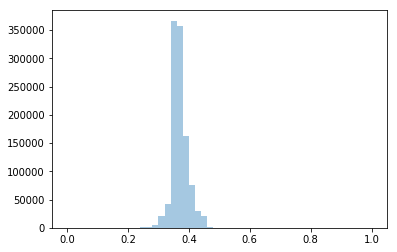

In [59]:
sns.distplot(utils.flatten(so_cal_sent_table['so_cal-sentence-norm']), kde=False)
plt.show()

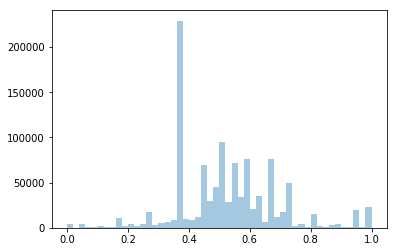

In [60]:
sns.distplot(utils.flatten(so_cal_sent_table['so_cal-sentence-adj-1-norm']), kde=False)
plt.show()

In [69]:
sent.print_anaysis(so_cal_sent_table, 264759774 , 'so_cal-sentence-adj-1-norm', 1)

Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

In [70]:
so_cal_chosen_s = ['so_cal-sentence-norm', 'so_cal-sentence-adj-1-norm']

# Opinion-BOW Sentence

In [71]:
op_bow_sent_table = utils.create_normalised_sent_table(reviews, 'opinion_bow-sentence')

In [72]:
op_bow_sent_table.head(5)

,id,comments,opinion_bow-sentence,opinion_bow-sentence-norm,opinion_bow-sentence-adj-1,opinion_bow-sentence-adj-1-norm,opinion_bow-sentence-adj-2,opinion_bow-sentence-adj-2-norm
201,247449510,"Great value, easy to get to",[0.5],[0.750],[0.5],[0.750],[0.5],[0.750]
202,248421191,Robin’s place was great. Very spacious and we ...,"[0.3333333333333333, 0.3333333333333333, 0.111...","[0.667, 0.667, 0.556, 0.500, 0.667]","[0.3333333333333333, 0.3333333333333333, 0.111...","[0.625, 0.625, 0.458, 0.375, 0.625]","[0.3333333333333333, 0.3333333333333333, 0.111...","[0.667, 0.667, 0.556, 0.500, 0.667]"
203,22938,Good location - easy access to Times Square an...,"[0.2857142857142857, 0.1, 0.5, 0.5, 0.2]","[0.643, 0.550, 0.750, 0.750, 0.600]","[0.2857142857142857, 0.1, 0.5, 0.5, 0.2]","[0.589, 0.450, 0.750, 0.750, 0.525]","[0.2857142857142857, 0.1, 0.5, 0.5, 0.2]","[0.643, 0.550, 0.750, 0.750, 0.600]"
204,234213,We had the best possible time in NYC and Russe...,"[0.1111111111111111, 0.42857142857142855, 0.33...","[0.556, 0.714, 0.667, 0.875, 0.667, 0.625, 0.7...","[0.1111111111111111, 0.42857142857142855, 0.33...","[0.458, 0.696, 0.625, 0.938, 0.625, 0.562, 0.7...","[0.1111111111111111, 0.42857142857142855, 0.33...","[0.556, 0.714, 0.667, 0.875, 0.667, 0.625, 0.7..."
205,264416,Three of us stayed at this place for a week- i...,"[0.4, 0.5, 0.0, 0.14285714285714285]","[0.700, 0.750, 0.500, 0.571]","[0.4, 0.5, 0.0, 0.14285714285714285]","[0.675, 0.750, 0.375, 0.482]","[0.4, 0.5, 0.0, 0.14285714285714285]","[0.700, 0.750, 0.500, 0.571]"


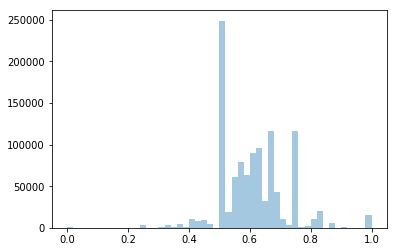

In [73]:
sns.distplot(utils.flatten(op_bow_sent_table['opinion_bow-sentence-norm']), kde=False)
plt.show()

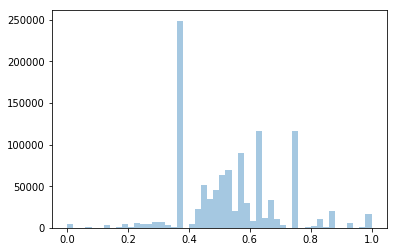

In [74]:
sns.distplot(utils.flatten(op_bow_sent_table['opinion_bow-sentence-adj-1-norm']), kde=False)
plt.show()

In [76]:
sent.print_anaysis(op_bow_sent_table, 264759774 , 'opinion_bow-sentence-adj-1-norm', 1)

Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

In [77]:
op_bow_chosen_s = ['opinion_bow-sentence-norm', 'opinion_bow-sentence-adj-1-norm']

# Opinion-Freq Sentence

In [78]:
op_freq_sent_table = utils.create_normalised_sent_table(reviews, 'opinion_freq-sentence')

In [79]:
op_freq_sent_table.head()

,id,comments,opinion_freq-sentence,opinion_freq-sentence-norm,opinion_freq-sentence-adj-1,opinion_freq-sentence-adj-1-norm,opinion_freq-sentence-adj-2,opinion_freq-sentence-adj-2-norm
201,247449510,"Great value, easy to get to",[0.3333333333333333],[0.667],[0.3333333333333333],[0.792],[0.3333333333333333],[0.667]
202,248421191,Robin’s place was great. Very spacious and we ...,"[0.2, 0.1111111111111111, 0.04, 0.0, 0.1666666...","[0.600, 0.556, 0.520, 0.500, 0.583]","[0.2, 0.1111111111111111, 0.04, 0.0, 0.1666666...","[0.625, 0.514, 0.425, 0.375, 0.583]","[0.2, 0.1111111111111111, 0.04, 0.0, 0.1666666...","[0.571, 0.508, 0.457, 0.429, 0.548]"
203,22938,Good location - easy access to Times Square an...,"[0.2, 0.058823529411764705, 0.25, 0.5, 0.14285...","[0.600, 0.529, 0.625, 0.750, 0.571]","[0.2, 0.058823529411764705, 0.25, 0.5, 0.14285...","[0.625, 0.449, 0.688, 1.000, 0.554]","[0.2, 0.058823529411764705, 0.25, 0.5, 0.14285...","[0.571, 0.471, 0.607, 0.786, 0.531]"
204,234213,We had the best possible time in NYC and Russe...,"[0.058823529411764705, 0.21428571428571427, 0....","[0.529, 0.607, 0.571, 0.650, 0.571, 0.571, 0.6...","[0.058823529411764705, 0.21428571428571427, 0....","[0.449, 0.643, 0.554, 0.750, 0.554, 0.554, 0.6...","[0.058823529411764705, 0.21428571428571427, 0....","[0.471, 0.582, 0.531, 0.643, 0.531, 0.531, 0.6..."
205,264416,Three of us stayed at this place for a week- i...,"[0.23529411764705882, 0.3333333333333333, 0.0,...","[0.618, 0.667, 0.500, 0.538]","[0.23529411764705882, 0.3333333333333333, 0.0,...","[0.669, 0.792, 0.375, 0.471]","[0.23529411764705882, 0.3333333333333333, 0.0,...","[0.597, 0.667, 0.429, 0.484]"


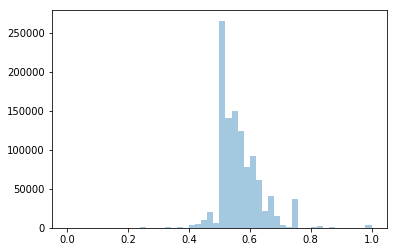

In [80]:
sns.distplot(utils.flatten(op_freq_sent_table['opinion_freq-sentence-norm']), kde=False)
plt.show()

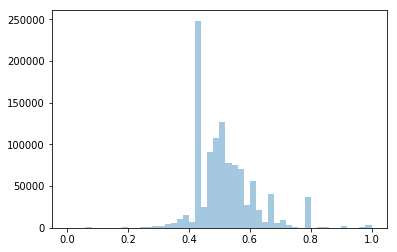

In [81]:
sns.distplot(utils.flatten(op_freq_sent_table['opinion_freq-sentence-adj-2-norm']), kde=False)
plt.show()

In [82]:
op_freq_chosen_s = ['opinion_freq-sentence-norm', 'opinion_freq-sentence-adj-2-norm']

# Normalisation

In [83]:
normalization = reviews[['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id', 'comments', 'hostCancelled', 'token_len', 'num_of_sents',
       'google_langs', 'google_langs_conf', 'langdetect_langs',
       'langdetect_langs_conf', 'other_langs', 'translated',]]
normalization.is_copy = False

In [84]:
#Afinn
normalization[['afinn_norm_o', 'afinn_norm_clipo_o']] = afinn_table[afinn_chosen_o]
normalization[['afinn_norm_s', 'afinn_norm_clipi_s']] = afinn_sent_table[afinn_chosen_s]

In [85]:
# Vader
normalization[['vader_norm_o', 'vader_norm_clipo_o']] = vader_table[vader_chosen_o]
normalization[['vader_norm_s', 'vader_norm_clipi_s']] = vader_sent_table[vader_chosen_s]

In [86]:
# S140
normalization[['s140_norm_o']] = s140_table[s140_chosen_o]
normalization[['s140_norm_s']] = s140_sent_table[s140_chosen_s]

In [87]:
# Socal
normalization[['so_cal_norm_o', 'so_cal_norm_clipo_o']] = so_cal_table[so_cal_chosen_o]
normalization[['so_cal_norm_s', 'so_cal_norm_clipi_s']] = so_cal_sent_table[so_cal_chosen_s]

In [88]:
# Opinion Bow
normalization[['op_bow_norm_o', 'op_bow_norm_clipo_o']] = op_bow_table[op_bow_chosen_o]
normalization[['op_bow_norm_s', 'op_bow_norm_clipi_s']] = op_bow_sent_table[op_bow_chosen_s]

In [89]:
# Opinion Freq
normalization[['op_freq_norm_o', 'op_freq_norm_clipo_o']] = op_freq_table[op_freq_chosen_o]
normalization[['op_freq_norm_s', 'op_freq_norm_clipi_s']] = op_freq_sent_table[op_freq_chosen_s]

In [90]:
normalization

,idReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,other_langs,translated,afinn_norm_o,afinn_norm_clipo_o,afinn_norm_s,afinn_norm_clipi_s,vader_norm_o,vader_norm_clipo_o,vader_norm_s,vader_norm_clipi_s,s140_norm_o,s140_norm_s,so_cal_norm_o,so_cal_norm_clipo_o,so_cal_norm_s,so_cal_norm_clipi_s,op_bow_norm_o,op_bow_norm_clipo_o,op_bow_norm_s,op_bow_norm_clipi_s,op_freq_norm_o,op_freq_norm_clipo_o,op_freq_norm_s,op_freq_norm_clipi_s
201,439,247449510,2018-03-28,2635362,4484,5688,"Great value, easy to get to",N,6,1,en,1.0,en,0.857139,0,None,0.331451,0.379468,[0.403],[0.625],0.860823,0.685094,[0.929],[0.923],0.5,[0.500],0.591816,0.520422,[0.374],[0.571],0.807355,0.765443,[0.750],[0.750],0.690672,0.843332,[0.667],[0.667]
202,440,248421191,2018-03-31,179985958,4484,5688,Robin’s place was great. Very spacious and we ...,N,55,5,en,1.0,en,0.999995,0,NaN,0.339024,0.395921,"[0.387, 0.355, 0.323, 0.323, 0.387]","[0.562, 0.438, 0.312, 0.312, 0.562]",0.838472,0.634523,"[0.813, 0.498, 0.472, 0.421, 0.830]","[0.798, 0.458, 0.430, 0.375, 0.817]",0.5,"[0.500, 0.500, 0.500, 0.500, 0.500]",0.591543,0.519460,"[0.388, 0.397, 0.370, 0.325, 0.434]","[0.661, 0.718, 0.546, 0.268, 0.946]",0.649093,0.428571,"[0.667, 0.667, 0.556, 0.500, 0.667]","[0.625, 0.625, 0.458, 0.375, 0.625]",0.507931,0.427818,"[0.600, 0.556, 0.520, 0.500, 0.583]","[0.571, 0.508, 0.457, 0.429, 0.548]"
203,441,22938,2010-01-03,61471,4989,7118,Good location - easy access to Times Square an...,N,40,5,en,1.0,en,0.999997,0,NaN,0.405451,0.540240,"[0.403, 0.387, 0.371, 0.387, 0.371]","[0.625, 0.562, 0.500, 0.562, 0.500]",0.976294,0.946363,"[0.851, 0.885, 0.738, 0.830, 0.680]","[0.839, 0.876, 0.717, 0.817, 0.655]",1.0,"[0.500, 0.500, 0.500, 0.500, 0.500]",0.615647,0.604175,"[0.365, 0.394, 0.370, 0.434, 0.342]","[0.518, 0.696, 0.546, 0.946, 0.375]",0.691878,0.519642,"[0.643, 0.550, 0.750, 0.750, 0.600]","[0.589, 0.450, 0.750, 0.750, 0.525]",0.564571,0.556604,"[0.600, 0.529, 0.625, 0.750, 0.571]","[0.571, 0.471, 0.607, 0.786, 0.531]"
204,442,234213,2011-04-21,446902,4989,7118,We had the best possible time in NYC and Russe...,N,88,8,en,1.0,en,0.999995,0,NaN,0.556011,0.867344,"[0.403, 0.452, 0.371, 0.435, 0.387, 0.403, 0.3...","[0.625, 0.812, 0.500, 0.750, 0.562, 0.625, 0.5...",0.993997,0.986417,"[0.919, 0.910, 0.836, 0.885, 0.813, 0.777, 0.8...","[0.913, 0.903, 0.823, 0.876, 0.798, 0.760, 0.8...",1.0,"[0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.5...",0.606974,0.573694,"[0.369, 0.400, 0.365, 0.376, 0.388, 0.377, 0.4...","[0.542, 0.732, 0.518, 0.582, 0.661, 0.589, 0.9...",0.719892,0.579272,"[0.556, 0.714, 0.667, 0.875, 0.667, 0.625, 0.7...","[0.458, 0.696, 0.625, 0.938, 0.625, 0.562, 0.7...",0.554736,0.534242,"[0.529, 0.607, 0.571, 0.650, 0.571, 0.571, 0.6...","[0.471, 0.582, 0.531, 0.643, 0.531, 0.531, 0.6..."
205,443,264416,2011-05-15,540879,4989,7118,Three of us stayed at this place for a week- i...,N,43,4,en,1.0,en,0.999997,0,NaN,0.398220,0.524529,"[0.484, 0.387, 0.323, 0.371]","[0.938, 0.562, 0.312, 0.500]",0.952482,0.892485,"[0.942, 0.813, 0.485, 0.710]","[0.937, 0.798, 0.444, 0.687]",1.0,"[1.000, 0.500, 0.500, 0.500]",0.592793,0.523853,"[0.388, 0.388, 0.340, 0.342]","[0.661, 0.661, 0.357, 0.375]",0.691878,0.519642,"[0.700, 0.750, 0.500, 0.571]","[0.675, 0.750, 0.375, 0.482]",0.557029,0.539456,"[0.618, 0.667, 0.500, 0.538]","[0.597, 0.667, 0.429, 0.484]"
206,444,843520,2012-01-06,1357796,4989,7118,A great apartment in the perfect location. I w...,N,20,2,en,1.0,en,0.999998,0,NaN,0.346558,0.412289,"[0.435, 0.339]","[0.750, 0.375]",0.838748,0.635146,"[0.917, 0.498]","[0.910, 0.458]",0.5,"[0.500, 0.500]",0.638901,0.685903,"[0.394, 0.342]","[0.696, 0.375]",0.678072,0.490255,"[0.750, 0.500]","[0.750, 0.375]",0.528176,0.473851,"[0.643, 0.500]","[0.633, 0.429]"
207,445,993034,2012-03-12,1757830,4989,7118,Russ is an amazing host and his awesome apartm...,N,73,5,en,1.0,en,0.999995,

In [91]:
normalization.to_csv('reviews_normalisations.csv')

# Average by norm whole 2 versions

In [4]:
norm_reviews = pd.read_csv('reviews_normalisations.csv', index_col=0)

In [5]:
sent_norm_tools = ['afinn_norm_s', 'vader_norm_s', 's140_norm_s', 'so_cal_norm_s', 'op_bow_norm_s']
sent_adj_tools = ['afinn_norm_clipi_s', 'vader_norm_clipi_s', 'so_cal_norm_clipi_s', 'op_bow_norm_clipi_s']
whole_norm_tools = ['afinn_norm_o', 'vader_norm_o', 's140_norm_o', 'so_cal_norm_o','op_bow_norm_o']
whole_adj_tools = ['afinn_norm_clipo_o', 'vader_norm_clipo_o', 'so_cal_norm_clipo_o', 'op_bow_norm_clipo_o']
sent_tools = sent_norm_tools + sent_adj_tools
whole_tools = whole_norm_tools + whole_adj_tools

In [6]:
sentence_set = norm_reviews[['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'hostCancelled', 'token_len', 'num_of_sents',
       'google_langs', 'google_langs_conf', 'langdetect_langs',
       'langdetect_langs_conf', 'other_langs', 'translated']+ sent_tools]

In [7]:
whole_avgs_best = ['afinn_norm_clipo_o','vader_norm_clipo_o','s140_norm_o', 'so_cal_norm_clipo_o', 'op_bow_norm_o']
sent_avgs_best = ['afinn_norm_clipi_s','vader_norm_s','s140_norm_s', 'so_cal_norm_clipi_s', 'op_bow_norm_s']
best_of_each = ['afinn_norm_clipo_o','vader_norm_s','s140_norm_s', 'so_cal_norm_o', 'op_bow_norm_o']
match_1 = list(set(whole_avgs_best) - set(['s140_norm_o']))
match_2 = list(set(sent_avgs_best) - set(['s140_norm_s']))
match_3 = list(set(best_of_each) - set(['s140_norm_s']))
match_4 = ['vader_norm_clipo_o', 'vader_norm_s']
match_5 = ['afinn_norm_clipo_o', 'afinn_norm_clipi_s']
match_6 = match_4 + match_5
match_7 = match_6 + ['so_cal_norm_clipi_s']
match_8 = match_4 + ['afinn_norm_clipo_o']
match_9 = match_6 + ['s140_norm_s']
match_10 = match_6 + ['so_cal_norm_clipo_o']
match_11 = match_4 + ['so_cal_norm_clipo_o']
match_12 = ['vader_norm_clipo_o', 'afinn_norm_clipo_o']
match_13 = match_12 + ['so_cal_norm_clipo_o']

In [8]:
avg_table = norm_reviews[['id','comments',  'token_len', 'num_of_sents', 'google_langs']]
avg_sent_table = norm_reviews[['id','comments',  'token_len', 'num_of_sents', 'google_langs']]
avg_sent_table.is_copy = False
avg_table.is_copy = False

In [9]:
avg_table['avg_whole_norm'] = np.sum(norm_reviews[whole_norm_tools], axis=1)/5
avg_table['avg_whole_adj'] = np.sum(norm_reviews[whole_adj_tools], axis=1)/4
avg_table['avg_whole_best'] = np.sum(norm_reviews[whole_avgs_best], axis=1)/5
avg_table['avg_best_of_each'] = np.sum(norm_reviews[best_of_each], axis=1)/5

In [12]:
sentence_set[list((set(sent_norm_tools)).union(set(sent_adj_tools)))] = sentence_set[list((set(sent_norm_tools)).union(set(sent_adj_tools)))].applymap(lambda x : utils.str_to_list(x))

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [14]:
sentence_set[sent_norm_tools].head()

,afinn_norm_s,vader_norm_s,s140_norm_s,so_cal_norm_s,op_bow_norm_s
201,[0.403],[0.929],[0.5],[0.374],[0.75]
202,"[0.387, 0.355, 0.323, 0.323, 0.387]","[0.813, 0.498, 0.472, 0.421, 0.83]","[0.5, 0.5, 0.5, 0.5, 0.5]","[0.388, 0.397, 0.37, 0.325, 0.434]","[0.667, 0.667, 0.556, 0.5, 0.667]"
203,"[0.403, 0.387, 0.371, 0.387, 0.371]","[0.851, 0.885, 0.738, 0.83, 0.68]","[0.5, 0.5, 0.5, 0.5, 0.5]","[0.365, 0.394, 0.37, 0.434, 0.342]","[0.643, 0.55, 0.75, 0.75, 0.6]"
204,"[0.403, 0.452, 0.371, 0.435, 0.387, 0.403, 0.3...","[0.919, 0.91, 0.836, 0.885, 0.813, 0.777, 0.83...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]","[0.369, 0.4, 0.365, 0.376, 0.388, 0.377, 0.434...","[0.556, 0.714, 0.667, 0.875, 0.667, 0.625, 0.7..."
205,"[0.484, 0.387, 0.323, 0.371]","[0.942, 0.813, 0.485, 0.71]","[1.0, 0.5, 0.5, 0.5]","[0.388, 0.388, 0.34, 0.342]","[0.7, 0.75, 0.5, 0.571]"


In [18]:
avg_sent_table['sent_avgs_norm'] = sentence_set[sent_norm_tools].sum(axis=1)/len(sent_norm_tools)
avg_sent_table['sent_avgs_adj'] = sentence_set[sent_adj_tools].sum(axis=1)/len(sent_adj_tools)
avg_sent_table['sent_avgs_best'] = sentence_set[sent_avgs_best].sum(axis=1)/len(sent_avgs_best)

In [21]:
avg_table['avg_sent_norm'] = sent.reduce_to_average(avg_sent_table['sent_avgs_norm'])
avg_table['avg_sent_adj'] = sent.reduce_to_average(avg_sent_table['sent_avgs_adj'])
avg_table['avg_sent_best'] = sent.reduce_to_average(avg_sent_table['sent_avgs_best'])

In [45]:
norm_reviews = sent.reduce_sentence_scores(norm_reviews, sent_tools, True)

In [50]:
norm_reviews[sent_tools] = norm_reviews[sent_tools].astype(float)

In [51]:
avg_table['avg_match_1'] = np.array(np.sum(norm_reviews[match_1], axis=1))/len(match_1)
avg_table['avg_match_2'] = np.array(np.sum(norm_reviews[match_2], axis=1))/len(match_2)
avg_table['avg_match_3'] = np.array(np.sum(norm_reviews[match_3], axis=1))/len(match_3)
avg_table['avg_match_4'] = np.array(np.sum(norm_reviews[match_4], axis=1))/len(match_4)
avg_table['avg_match_5'] = np.array(np.sum(norm_reviews[match_5], axis=1))/len(match_5)
avg_table['avg_match_6'] = np.array(np.sum(norm_reviews[match_6], axis=1))/len(match_6)
avg_table['avg_match_7'] = np.array(np.sum(norm_reviews[match_7], axis=1))/len(match_7)
avg_table['avg_match_8'] = np.array(np.sum(norm_reviews[match_8], axis=1))/len(match_8)
avg_table['avg_match_9'] = np.array(np.sum(norm_reviews[match_9], axis=1))/len(match_9)
avg_table['avg_match_10'] = np.array(np.sum(norm_reviews[match_10], axis=1))/len(match_10)
avg_table['avg_match_11'] = np.array(np.sum(norm_reviews[match_11], axis=1))/len(match_11)
avg_table['avg_match_12'] = np.array(np.sum(norm_reviews[match_12], axis=1))/len(match_12)
avg_table['avg_match_13'] = np.array(np.sum(norm_reviews[match_13], axis=1))/len(match_13)

In [53]:
avg_tools = ['avg_match_1','avg_match_2','avg_match_3','avg_match_4','avg_match_5','avg_match_6','avg_match_7',
             'avg_match_8','avg_match_9','avg_match_10','avg_match_11','avg_match_12','avg_match_13','avg_sent_norm','avg_sent_adj','avg_sent_best','avg_whole_norm','avg_whole_adj','avg_whole_best', 'avg_best_of_each']


In [54]:
avg_table[avg_tools] = avg_table[avg_tools].astype(float)

In [109]:
avg_table[(avg_table['avg_whole_norm'] <0.3)]

,id,comments,token_len,num_of_sents,google_langs,avg_whole_norm,avg_whole_adj,avg_whole_best,avg_best_of_each,avg_sent_norm,avg_sent_adj,avg_sent_best,avg_match_1,avg_match_2,avg_match_3,avg_match_4,avg_match_5,avg_match_6,avg_match_7,avg_match_8,avg_match_9,avg_match_10,avg_match_11,avg_match_12,avg_match_13
232,6236,Dead cockroaches. Cat hair everywhere. Not ver...,8,3,en,0.260298,0.146986,0.176168,0.258454,0.412,0.325,0.396,0.220211,0.36950,0.405567,0.1650,0.324940,0.244970,0.238176,0.208627,0.295976,0.195976,0.110000,0.147940,0.098627
375,29344,The apartment is not the place shown in the pi...,39,3,en,0.273896,0.172489,0.196571,0.275544,0.346,0.298,0.341,0.245713,0.34325,0.428930,0.1690,0.362791,0.265896,0.258717,0.222528,0.279317,0.226378,0.135436,0.164791,0.132630
384,69674,We stayed at Shun's place for a week in july. ...,97,8,en,0.276642,0.174527,0.200677,0.277534,0.418,0.381,0.426,0.250846,0.42275,0.466918,0.2400,0.368650,0.304325,0.308060,0.275433,0.331060,0.260079,0.187698,0.173150,0.143131
481,2295972,We've already stayed five times with airbnb an...,82,5,en,0.225142,0.074890,0.134379,0.207693,0.365,0.227,0.326,0.167974,0.28225,0.338867,0.1585,0.210160,0.184330,0.173264,0.158107,0.247464,0.147464,0.105667,0.078660,0.052440
538,12649702,My first experience with Airbnb in this apartm...,330,15,en,0.241306,0.086892,0.135601,0.221120,0.374,0.341,0.362,0.169501,0.38525,0.395400,0.2380,0.214370,0.226185,0.233948,0.193247,0.234348,0.185461,0.166188,0.051870,0.042102
561,20676723,This place is horrible and not what is represe...,22,3,en,0.196904,0.043745,0.123110,0.183846,0.243,0.109,0.179,0.153888,0.18175,0.286307,0.1130,0.191990,0.152495,0.121996,0.133660,0.155396,0.121996,0.075333,0.087490,0.058326
587,31027432,He is very quiet but gave no idea about the ar...,42,3,en,0.271267,0.153246,0.181176,0.266341,0.347,0.332,0.332,0.226470,0.37275,0.432176,0.1985,0.324940,0.261720,0.252976,0.230960,0.242776,0.214384,0.140680,0.147940,0.106973
606,41269884,Our apartment building in Philadelphia caught ...,159,6,en,0.257577,0.138452,0.173960,0.244059,0.364,0.329,0.360,0.217450,0.36675,0.410324,0.2105,0.238490,0.224495,0.245796,0.198660,0.246196,0.205660,0.183774,0.087490,0.101767
1780,2838353,"SHOCKING describes best the place, beginning w...",256,16,en,0.285734,0.205235,0.220537,0.290915,0.420,0.395,0.429,0.275672,0.43525,0.491894,0.2565,0.385234,0.320867,0.323294,0.297489,0.337894,0.282369,0.213792,0.189734,0.169281
2143,108810133,DO NOT GO HERE! I wouldn't recommend this plac...,239,20,en,0.240116,0.112347,0.148457,0.225740,0.373,0.310,0.360,0.185571,0.35550,0.374425,0.1845,0.252160,0.218330,0.219264,0.175440,0.249664,0.174664,0.123000,0.078660,0.052440


In [212]:
avg_table.to_csv('sent_avgs.csv')

In [213]:
len(avg_table)

225448

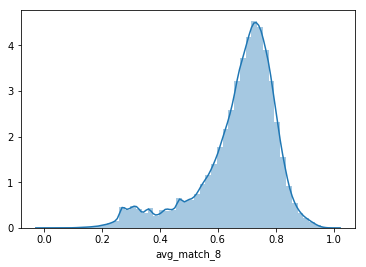

In [104]:
sns.distplot(avg_table['avg_match_8'])
plt.show()

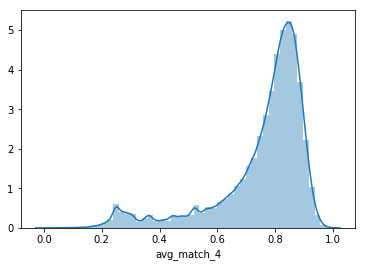

In [216]:
sns.distplot(avg_table['avg_match_4'])
plt.show()

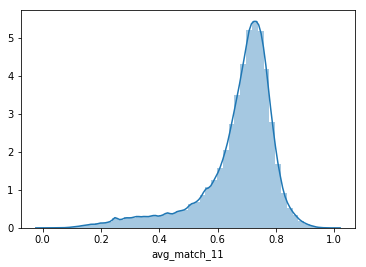

In [106]:
sns.distplot(avg_table['avg_match_11'])
plt.show()

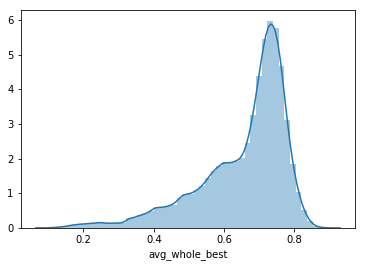

In [111]:
sns.distplot(avg_table['avg_whole_best'])
plt.show()

In [158]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
stopWords = set(stopwords.words('english'))

In [208]:
bad_reviews = vader_table[(vader_table['vader-norm'] <0.2)]

In [209]:
r, vc, v, idf = lang.pipeline(bad_reviews['comments'], stopWords)

In [210]:
vocab_table = lang.create_vocab_count_table(vc)

In [211]:
vocab_table.sort_values(by='counts', ascending=False).head(40)

,counts,word
6,1732,apartment
7,928,place
100,833,us
85,723,host
21,713,stay
55,681,room
173,672,one
104,619,would
16,555,airbnb
54,527,night


# Comparison 

In [102]:
utils.get_comments(norm_reviews, 'id', 106703, 'comments')

"Is glad to stay in Tina's Apt. the apt is just closed to the convinent store (around the corner), food (1 block away) and take another 7 to 10 blocks to times square.."